In [ ]:
import numpy as np
import os
import json
from datetime import datetime
from pathlib import Path, PosixPath
import pickle

from benchmark_utils import laplacian, norm_laplacian
from benchmark_distances import distance_frobenius, distance_procrustes_LE
import scipy
import scipy.sparse as ss

from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
from TemporalNetwork import ContTempNetwork

from sklearn.cluster import KMeans

In [3]:
net_heat1 = ContTempNetwork.load('evolving_SBM_net1_b')

In [4]:
net_heat1.compute_laplacian_matrices(random_walk = False, save_adjacencies=True)

## LCE Filter

In [23]:
selected_lamdas = np.logspace(-3,1,10)
window = 500

In [24]:
Conditional_S_selected1 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net1_b/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected1.append(S_rate['window_S'][f'{lamda:.11f}'])

Text(0.0, 1.0, '(B) Conditional Entropy - Network1_b')

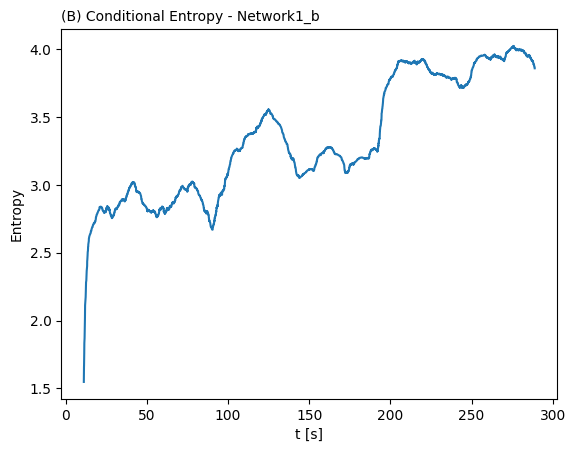

In [27]:
index = 6
S = Conditional_S_selected1[index]

plt.plot(net_heat1.times[window // 2 + 1: -window // 2], S[1:], alpha=1)
plt.xlabel("t [s]")
plt.ylabel("Entropy")
plt.title("(B) Conditional Entropy - Network1_b", loc='left', fontsize=10)

## laplacian spectrum similarity

In [5]:
def laplacian_spectrum_similarity(data, window_length, normalize=True, n_eigen=6):
    """
    Compute Laplacian Anomaly Detection statistic [Huang et al. 2020]

    :param data (list of DGL graphs): dynamic network sequence
    :param window_length (int): length of backward window
    :param normalize (bool): use symmetric Laplacian matrix
    :param n_eigen (int): nb of eigenvalues used to compute the 'signature'
    :return:
    """

    # Lap_spec = []
    # for i in range(len(data)):
    #     A = data[i]
    #     if not isinstance(A, ss.csr_matrix):
    #         A = ss.csr_matrix(A.adj().to_dense().numpy())
    #     if normalize:
    #         L = norm_laplacian(A)
    #     else:
    #         L = laplacian(A)

    #     L = L.asfptype()
    #     try:
    #         w = ss.linalg.eigsh(L, return_eigenvectors=False, k=n_eigen, which='SA')
    #         Lap_spec.append(w / np.linalg.norm(w))
    #     except:
    #         return None

    data.compute_laplacian_matrices(random_walk = normalize)
    Lap_spec = []
    
    for i, L in enumerate(data.laplacians):
        #print(i)
        L = L.asfptype()
        try:
            w = ss.linalg.eigsh(L, return_eigenvectors=False, k=n_eigen, which='SA')
            #print(w / np.linalg.norm(w))
            Lap_spec.append(w / np.linalg.norm(w))
        except:
            w = np.zeros(n_eigen)
            Lap_spec.append(w)
            #return None
            
    Zsc = []
    
    #for i in range(window_length, len(data)):
    for i in range(window_length, len(data.laplacians)):
        window = np.stack(Lap_spec[i - window_length:i], axis=1)
        try:
            u, s, v = scipy.linalg.svd(window, compute_uv=True)
        except:
            return None
        Zsc.append(1 - abs(np.dot(u[:, 0], Lap_spec[i])))

    #dzsc = np.clip(np.array(Zsc[1:]) - np.array(Zsc[:-1]), a_min=0, a_max=np.Inf)

    #print(Zsc)
    #return Zsc, np.arange(window_length, len(data))
    return Zsc, np.arange(window_length, len(data.laplacians))

In [11]:
window_length = 100
n_eigen= 6

In [12]:
zsc, r = laplacian_spectrum_similarity(net_heat1, window_length=window_length, n_eigen=n_eigen)

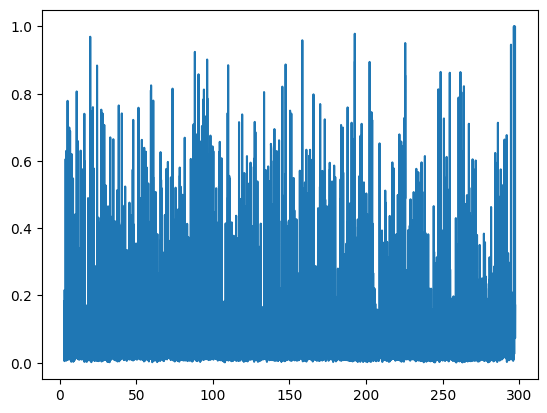

In [13]:
plt.plot(net_heat1.times[window_length // 2 : len(net_heat1.times) - window_length // 2 -1], zsc)

## NCPD

In [9]:
def NCPD(data, window_length, n_eigen, normalize=False):
    """
    Compute NCPD statistics of the Spectral Clustering method [Cribben et al. 2017]
    :param data (list of DGL graphs): dynamic network sequence:
    :param window_length (int): length of backward window
    :param n_eigen (int): nb of eigenvalues used to compute the node embeddings
    :return:
    """


    if not isinstance(data[0], ss.csr_matrix):
        data = [ss.csr_matrix(data[i].toarray()) for i in range(len(data))]

    gamma = []
    for i in range(window_length, len(data) - window_length):
        avl = sum(data[i - window_length:i]) / window_length
        avr = sum(data[i:i + window_length]) / window_length
        if normalize:
            lapl = norm_laplacian(avl)
            lapr = norm_laplacian(avr)
        else:
            lapl = laplacian( avl )
            lapr = laplacian( avr )

        vl, wl = ss.linalg.eigsh(lapl, n_eigen, which="SA")
        vr, wr = ss.linalg.eigsh(lapr, n_eigen, which="SA")
        xl = KMeans(n_clusters=n_eigen, n_init='auto').fit(wl[:, :n_eigen])
        xr = KMeans(n_clusters=n_eigen, n_init='auto').fit(wr[:, :n_eigen])

        UL = np.stack([xl.cluster_centers_[xl.labels_[j]] for j in range(data[i].shape[0])], axis=0)
        UR = np.stack([xr.cluster_centers_[xr.labels_[j]] for j in range(data[i].shape[0])], axis=0)

        s = scipy.linalg.svd(UL.transpose().dot(UR), compute_uv=False)
        gamma.append(np.sum(s))

    d_gamma = np.maximum(np.abs(np.array(gamma)[1:-1] - np.array(gamma)[:-2]),
                         np.abs(np.array(gamma)[1:-1] - np.array(gamma)[2:]))

    return d_gamma, 1 + np.arange(window_length, len(data) - window_length -2)

In [14]:
d_gamma, t = NCPD(net_heat1.adjacencies, window_length=window_length, n_eigen=n_eigen)

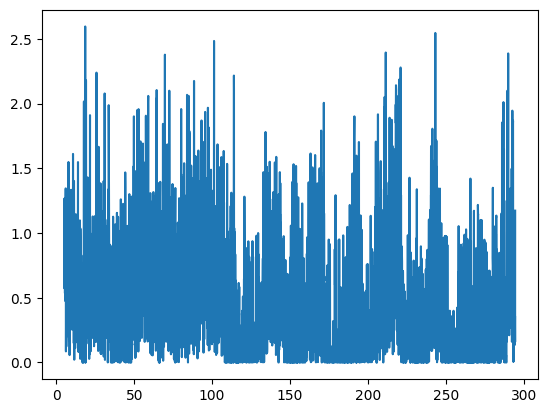

In [16]:
plt.plot(net_heat1.times[t], d_gamma)

## CUMSUM

In [47]:
def CUMSUM(data, window_length):
    """
    CUMSUM statistics from Optimal network online change point localisation [Yu, Padilla, Wang & Rinaldo 2021] (without USVT)

    :param data:
    :param window_length:
    :return:
    """


    if not isinstance(data[0], ss.csr_matrix):
        data = [ss.csr_matrix(data[i].toarray()) for i in range(len(data))]

    A = [data[2*i].toarray() for i in range(len(data) //2 )]
    B = [data[2*i + 1].toarray() for i in range(len(data) //2 )]

    Y = []
    for i in range(window_length, len(A) - window_length):

        C_A = 1.0 / (np.sqrt(2 * window_length)) * (np.sum(np.stack(A[i-window_length: i], axis=2), axis=2) - np.sum(np.stack(A[i: i+window_length], axis=2), axis=2))
        C_B = 1.0 / (np.sqrt(2 * window_length)) * (np.sum(np.stack(B[i-window_length: i], axis = 2), axis = 2) - np.sum(np.stack(B[i: i+window_length], axis = 2), axis = 2))

        C_B = C_B / np.linalg.norm(C_B)

        Y.append(np.sum(C_A * C_B))

    times = np.arange(2*window_length, len(data) - 2*window_length, 2)


    return Y, times

In [64]:
Y, t = CUMSUM(net_heat1.adjacencies, window_length=window_length)

In [69]:
net_heat1.times[t]

Index([ 9.041835681634861,  9.060758571284287,  9.099378679686378,
        9.195833246186314,  9.242218573117928,  9.386871362258457,
        9.472189252458273,   9.51587460910536,  9.657250133909045,
        9.729210349513158,
       ...
        290.0286153244658,  290.0458591653082, 290.08865453033275,
       290.10298608790225,  290.2281333998352,  290.2886970491112,
       290.32495978309544, 290.40134791669294,  290.5455205781314,
        290.6369177183311],
      dtype='float64', name='times', length=4332)

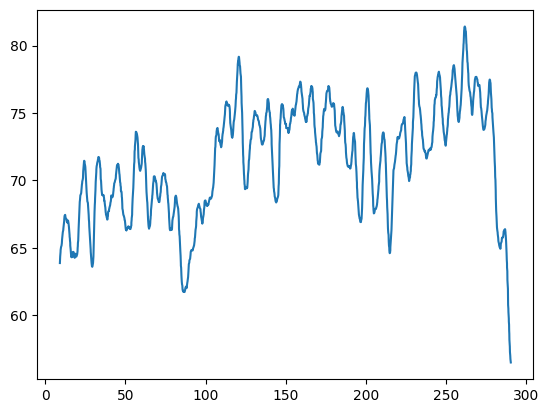

In [70]:
plt.plot(net_heat1.times[t][1:], Y)

## CUMSUM 2

In [78]:
def CUMSUM_2(data, window_length):
    """
    CUMSUM statistics from Change-Point Detection in Dynamic Networks with Missing Links [Enikeeva & Klopp 2021]

    :param data:
    :param window_length:
    :return:
    """

    if not isinstance(data[0], ss.csr_matrix):
        data = [ss.csr_matrix(data[i].toarray()) for i in range(len(data))]

    data = [data[i].toarray() for i in range(len(data))]
    stat = []

    for i in range(window_length, len(data) - window_length):

        csum = 1.0 / (np.sqrt(2 * window_length)) * (np.sum(np.stack(data[i - window_length: i ], axis=2), axis=2) - np.sum(np.stack(data[i: i+ window_length], axis=2), axis=2))

        stat.append(np.linalg.norm(csum, ord=2))

    return stat, np.arange( window_length, len(data) - window_length)

In [79]:
stat, t = CUMSUM_2(net_heat1.adjacencies, window_length=window_length)

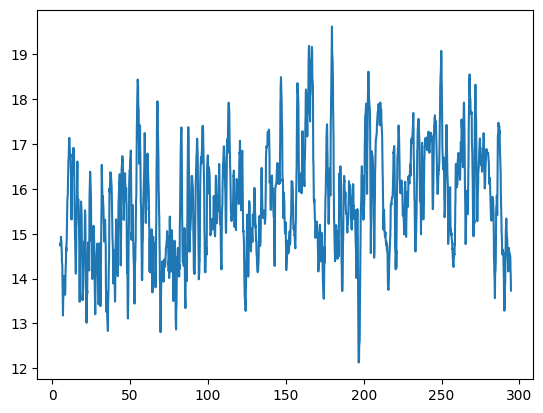

In [83]:
plt.plot(net_heat1.times[t], stat)

## Avg Frobenius Distance

In [30]:
def avg_frobenius_distance(data, window_length, diff=False):
    """
    Computes averaged Frobenius distance statistics over a backward window

    :param data:
    :param window_length:
    :return:
    """

    if not isinstance(data[0], np.ndarray):
        data = [data[i].toarray() for i in range(len(data))]

    avg_dist = []
    for i in range(window_length, len(data)):
        dist_t = []
        for j in range(1, window_length + 1):
            dist_t.append(distance_frobenius(data[i], data[i - j]))
        avg_dist.append( np.mean(dist_t) )

    if diff:
        d_avg_dist = np.abs(np.array(avg_dist[1:]) - np.array(avg_dist[:-1]))
        return d_avg_dist, np.arange(window_length+1, len(data))

    return np.array(avg_dist), np.arange(window_length, len(data))

In [33]:
frob_dist, t_frob = avg_frobenius_distance(net_heat1.adjacencies, window_length=window_length)

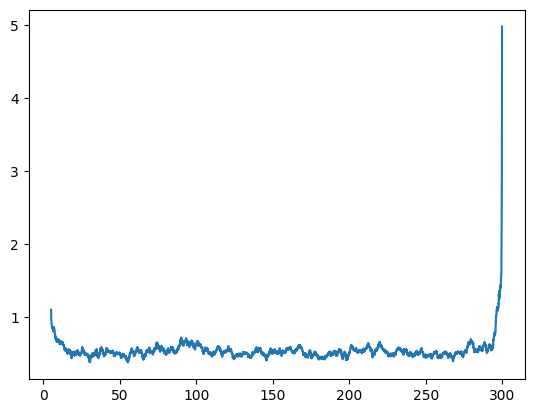

In [34]:
plt.plot(net_heat1.times[t_frob], frob_dist)

## Avg procrutes distance

In [37]:
def avg_procrustes_distance(data, window_length, n_eigen=2, diff=False, normalize=False):
    """
    Computes averaged Procrustes distance statistics over a backward window

    :param data:
    :param window_length:
    :param n_eigen:
    :return:
    """

    if not isinstance(data[0], np.ndarray):
        data = [data[i].toarray() for i in range(len(data))]

    avg_dist = []
    for i in range(window_length, len(data)):
        dist_t = []
        for j in range(1, window_length + 1):
            dist_t.append( distance_procrustes_LE(data[i], data[i - j], k=n_eigen, normalize=normalize))
        avg_dist.append(np.mean(dist_t))

    if diff:
        d_avg_dist = np.abs(np.array(avg_dist[1:]) - np.array(avg_dist[:-1]))
        return d_avg_dist, np.arange(window_length + 1, len(data))

    return np.array(avg_dist), np.arange(window_length, len(data))

## 

In [38]:
proc_dist, t_proc = avg_procrustes_distance(net_heat1.adjacencies, window_length=window_length)

/home/b/skoove/Desktop/entropy/flow_stability/benchmark_distances.py:143: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(s)


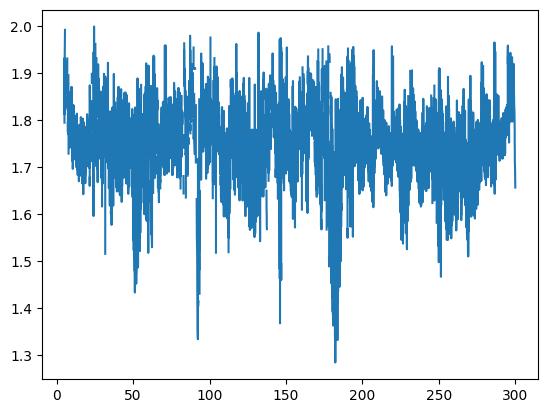

In [39]:
plt.plot(net_heat1.times[t_proc], proc_dist)